In [1]:
import os

import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

## Подготавливаем данные

Для начала скачаем данные в dataframe. Сегодня будем предсказывать просмотры wiki-страницы Machine Learning.

In [3]:
df = pd.read_csv("wiki.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


## Предсказываем с помощью ARIMA

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

 Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [5]:
df.columns

Index(['date', 'count', 'lang', 'page', 'rank', 'month', 'title'], dtype='object')

In [6]:
df = df.loc[:, ['date', 'count']]
df.head()

,date,count
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264


C:\python\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\python\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\python\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



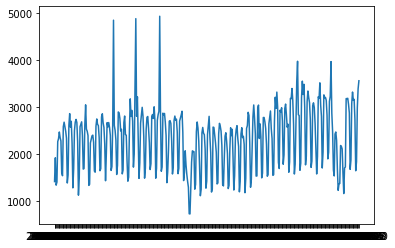

In [7]:
plt.plot(df['date'], df['count'])

In [8]:
round(sm.tsa.stattools.adfuller(df.loc[:, 'count'])[1], 3)

0.015

In [9]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = list(product(ps, qs, Ps, Qs))



In [12]:
df

,date,count
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264
...,...,...
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389


In [14]:
results = []
best_measurement_error = float("inf")

for param in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.loc[:, 'count'], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 24*7))
        model.fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    error = model.measurement_error
    #сохраняем лучшую модель, aic, параметры
    if error < best_measurement_error:
        best_model = model
        best_measurement_error = error
        best_param = param
    results.append([param, model.measurement_error])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'measurement_error']
print(result_table.sort_values(by = 'measurement_error', ascending=True).head())

C:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\python\lib\site-packages\statsmodels\